In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define basic data

In [5]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)


# because the last two decade used different untouched sample, 
# so here we merge them together
Untouched_sample = [Sample_Landsat] * 8 + [Sample_Sentinel] * 2

In [9]:
# get the classification of this study
My_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

#### Calculate the accuracy

In [7]:
# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

In [10]:
# construc year:value dict to dilineate the value from mosaiced classifications

# get the value dict of my result 
My_value = dict(zip(year_range,range(10,0,-1)))

# get the GAIA value dict
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# add {2019:1} to the dictionary, because GAIA does not 
# extend to 2019, we just use its latest pixel of 2018
GAIA_value.update({2019:1})

In [35]:
# calculate the GAIA accuracy using the untouched control samples

Accuracy_df_lis = []

for i,year in enumerate(year_range):
    
    # get the img and untouched sample
    sample = Untouched_sample[i]
    
    # get the value that correspoding the year
    year_GAIA = int(year[-4:])
    
    # get the classificaiton, rename the band so we can use Accuracy_assesment module
    img_my   = ee.Image(My_img.gte(My_value[year])).rename('classification')
    img_GAIA = ee.Image(GAIA_img.gte(GAIA_value[year_GAIA])).rename('classification')
   
    # extract the img pixel value to test_sample
    test_with_My   = img_my.sampleRegions(  collection = sample, 
                                            properties = ['Built'], 
                                            scale      = 30)
    
    test_with_GAIA = img_GAIA.sampleRegions( collection = sample, 
                                             properties = ['Built'], 
                                             scale      = 30)
    

    # compute the accuracy and put them into a df
    Acc_GAIA_dict = {}
    Acc_GAIA_dict[('GAIA',year)] = Accuracy_assesment(test_with_GAIA).Stp_1_Calculate_Accuracy()
    Acc_GAIA_df = pd.DataFrame(Acc_GAIA_dict).T
    
    Acc_My_dict = {}
    Acc_My_dict[('My',year)] = Accuracy_assesment(test_with_My).Stp_1_Calculate_Accuracy()
    Acc_My_df = pd.DataFrame(Acc_My_dict).T
    
    # append the acc_df to df_list
    Acc_df = pd.concat([Acc_My_df,Acc_GAIA_df])
    Accuracy_df_lis.append(Acc_df)
    
    # print out the process
    print(f'Accuracy computation of GAIA_{year} complete!')
    

Accuracy computation of GAIA_1990_1992 complete!
Accuracy computation of GAIA_1993_1995 complete!
Accuracy computation of GAIA_1996_1998 complete!
Accuracy computation of GAIA_1999_2001 complete!
Accuracy computation of GAIA_2002_2004 complete!
Accuracy computation of GAIA_2005_2007 complete!
Accuracy computation of GAIA_2008_2010 complete!
Accuracy computation of GAIA_2011_2013 complete!
Accuracy computation of GAIA_2014_2016 complete!
Accuracy computation of GAIA_2017_2019 complete!


In [42]:
# # Formatting the GAIA_accuracy dataframe
# Accuracy_df = pd.concat(Accuracy_df_lis).reset_index()
# Accuracy_df.columns =['Type','year','Overall_ACC', 'Precisioin_built','Precisioin_non_built', 'Recall_built', 'Recall_non_built']

# # save to disk
# Accuracy_df.to_csv('./Result/Accuracy_comparision.csv',index=False)

# load the df
Accuracy_df = pd.read_csv('./Result/Accuracy_comparision.csv')

##### Make a figure for comparison

In [50]:
Accuracy_df['year'] = Accuracy_df['year'].astype('category')

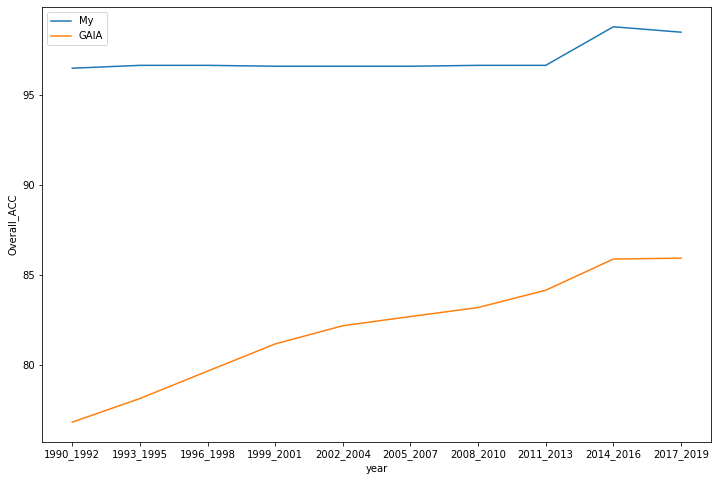

In [54]:
plt.figure(figsize=(12,8))

sns.lineplot(data=Accuracy_df[Accuracy_df['Type']=='My'][['year','Overall_ACC']], x = 'year', y ='Overall_ACC', label='My')
sns.lineplot(data=Accuracy_df[Accuracy_df['Type']=='GAIA'][['year','Overall_ACC']], x = 'year', y ='Overall_ACC', label='GAIA')